<a href="https://colab.research.google.com/github/matt2fu/nba_data_analytics/blob/main/nba_data_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NBA Data Analytics Project

#Motivation


This project focuses on the National Basketball Association (NBA). We wanted to find what factors led to a home team not only winning a game, but dominating the away team. "Dominance" was measured using the home team's plus minus score, i.e. the point difference of the home team minus the away team. Then, using ML techniques, we analyzed how different play styles correlated to different magnitudes of dominance.

For this project, we use two datasets: one on previous NBA games (60,000+) and one on the stats of each player in each previous NBA game. The NBA games dataset allow us to analyze the different aspects of the game a home team is doing well, and the consequential success the team is seeing. The dataset of the stats of each player in each previous NBA game allow us to ask more interesting questions on how the home team dynamic is. We can inspect if one player is scoring the most points or if the points are more distributed. 

#Imports/Setup

In [ ]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns

#Data Loading and Preprocessing



Download the following CSV files: 
*   Game Data: https://www.kaggle.com/datasets/wyattowalsh/basketball ("csv" folder to "game.csv" file)
*   Game Player Data: https://www.kaggle.com/datasets/nathanlauga/nba-games?select=games_details.csv
*   Game Dates: https://www.kaggle.com/datasets/nathanlauga/nba-games?select=games.csv

## Game Data

This file contains the main data we will work with. It contains over 60,000 rows of NBA games. The columns contain comprehensive statistics for each game played such as field goals made, 3 pointers attempted, and more for the home and away team. For the unfamiliar, here is a glossary on the abbreviations for each statistic: https://www.nba.com/stats/help/glossary

In [ ]:
# load data
game_df = pd.read_csv("game.csv")

After loading in our initial data, we want to drop any extra columns that we are not interested in. Since the other datasets we are using are from a different source, most of the columns that contains ID are irrelevant, so we will drop them. We keep the game ID simply so that we have a unique identifier for each row. We also drop columns that give repetitive stats or are not as impactful to a team's performance. Finally, we want to convert the dates to datetime objects.

In [ ]:
# drop extra columns
game_dropped_df = game_df[['team_abbreviation_home', 'team_name_home', 'game_id', 'game_date', 'wl_home', 'fgm_home', 'fga_home', 'fg_pct_home', 'fg3m_home', 'fg3a_home', 'fg3_pct_home', 'ftm_home', 'fta_home', 'ft_pct_home', 'oreb_home', 'dreb_home', 'ast_home', 'stl_home', 'blk_home', 'tov_home', 'pts_home', 'plus_minus_home']]

# remove null rows
game_dropped_nulls_df = game_dropped_df.dropna()

# convert dates to datetime objects
game_dropped_nulls_df['game_date'] = game_dropped_nulls_df['game_date'].apply(lambda x : pd.to_datetime(x))

# rename df
game_inter_df = game_dropped_nulls_df

<ipython-input-24-5ae6967f25c0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_dropped_nulls_df['game_date'] = game_dropped_nulls_df['game_date'].apply(lambda x : pd.to_datetime(x))


In [ ]:
# preview data
game_inter_df.head()

,team_abbreviation_home,team_name_home,game_id,game_date,wl_home,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,...,fta_home,ft_pct_home,oreb_home,dreb_home,ast_home,stl_home,blk_home,tov_home,pts_home,plus_minus_home
17653,SDC,San Diego Clippers,28100136,1981-11-24,L,40.0,85.0,0.471,1.0,6.0,...,33.0,0.636,17.0,25.0,15.0,9.0,4.0,18.0,102,-7
17982,PHL,Philadelphia 76ers,28100466,1982-01-23,W,39.0,97.0,0.402,1.0,1.0,...,35.0,0.600,25.0,21.0,22.0,11.0,3.0,18.0,100,13
18036,MIL,Milwaukee Bucks,28100518,1982-02-05,W,48.0,87.0,0.552,1.0,3.0,...,27.0,0.741,16.0,30.0,33.0,9.0,9.0,17.0,117,25
18081,CHI,Chicago Bulls,28100564,1982-02-13,L,33.0,93.0,0.355,3.0,10.0,...,29.0,0.724,30.0,18.0,24.0,7.0,4.0,20.0,90,-30
18144,NJN,New Jersey Nets,28100625,1982-02-24,L,41.0,86.0,0.477,2.0,6.0,...,29.0,0.759,15.0,25.0,27.0,11.0,9.0,28.0,106,-7


In [ ]:
# metadata
game_inter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40828 entries, 17653 to 62366
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   team_abbreviation_home  40828 non-null  object        
 1   team_name_home          40828 non-null  object        
 2   game_id                 40828 non-null  int64         
 3   game_date               40828 non-null  datetime64[ns]
 4   wl_home                 40828 non-null  object        
 5   fgm_home                40828 non-null  float64       
 6   fga_home                40828 non-null  float64       
 7   fg_pct_home             40828 non-null  float64       
 8   fg3m_home               40828 non-null  float64       
 9   fg3a_home               40828 non-null  float64       
 10  fg3_pct_home            40828 non-null  float64       
 11  ftm_home                40828 non-null  float64       
 12  fta_home                40828 non-null  fl

## Game Players Data

This file contains the games player data we will work with. Each row contains the data for a particular game with a particular player, and that player's stats in that game. 

In [ ]:
# load data
game_players_df = pd.read_csv("games_details.csv")

<ipython-input-6-9201c6effccb>:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  game_players_df = pd.read_csv("games_details.csv")


Again, we want to drop any extra rows that contain information we are not interested in. For this project, we will only focus on the points a player scored in a game: the "PF" column. We will rename this column from "PF" to "PTS" as well.

In [ ]:
# drop extra columns
game_players_dropped_df = game_players_df[['GAME_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_NAME', 'PF']]

# drop null rows
game_players_dropped_nulls_df = game_players_dropped_df.dropna()

# rename 'PF' column to 'PTS'
game_players_dropped_nulls_df['PTS'] = game_players_dropped_nulls_df['PF']
game_players_dropped_nulls_df = game_players_dropped_nulls_df.drop(columns = ['PF'])

# rename df
game_players_inter_df = game_players_dropped_nulls_df

<ipython-input-27-225731c5eb38>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_players_dropped_nulls_df['PTS'] = game_players_dropped_nulls_df['PF']


In [ ]:
# data preview
game_players_inter_df.head()

,GAME_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_NAME,PTS
0,22200477,SAS,San Antonio,Romeo Langford,5.0
1,22200477,SAS,San Antonio,Jeremy Sochan,1.0
2,22200477,SAS,San Antonio,Jakob Poeltl,4.0
3,22200477,SAS,San Antonio,Devin Vassell,1.0
4,22200477,SAS,San Antonio,Tre Jones,2.0


In [ ]:
# metadata
game_players_inter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558938 entries, 0 to 668627
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   GAME_ID            558938 non-null  int64  
 1   TEAM_ABBREVIATION  558938 non-null  object 
 2   TEAM_CITY          558938 non-null  object 
 3   PLAYER_NAME        558938 non-null  object 
 4   PTS                558938 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 25.6+ MB


## Game Dates Data

This dataset is from the same source as the game players datset we just imported. The purpose of loading this dataset in is to join it to the game players dataset so that we have the date information in our new dataframe.

In [ ]:
# load data
game_dates_df = pd.read_csv("games.csv")

We only need to keep the game_id and date columns.


In [ ]:
# drop extra columns
game_dates_dropped_df = game_dates_df[['GAME_DATE_EST', 'GAME_ID']]

# drop null rows
game_dates_dropped_nulls_df = game_dates_dropped_df.dropna()

# rename df
game_dates_inter_df = game_dates_dropped_nulls_df

In [ ]:
# preview data
game_dates_inter_df.head()

,GAME_DATE_EST,GAME_ID
0,2022-12-22,22200477
1,2022-12-22,22200478
2,2022-12-21,22200466
3,2022-12-21,22200467
4,2022-12-21,22200468


In [ ]:
# metadata
game_dates_inter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26651 entries, 0 to 26650
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   GAME_DATE_EST  26651 non-null  object
 1   GAME_ID        26651 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 416.5+ KB


##Merge Game Players Data and Game Dates Data

Here, we merge the dates with the game players dataset. We also need to convert the date column to a datetime object.

In [ ]:
# merge game_players_inter_df and game_dates_inter_df
game_players_df = game_players_inter_df.merge(game_dates_inter_df, left_on = 'GAME_ID', right_on = 'GAME_ID')

# convert date column to datetime object
game_players_df['GAME_DATE_EST'] = game_players_df['GAME_DATE_EST'].apply(lambda x : pd.to_datetime(x))

In [ ]:
# preview data
game_players_df.head()

,GAME_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_NAME,PTS,GAME_DATE_EST
0,22200477,SAS,San Antonio,Romeo Langford,5.0,2022-12-22
1,22200477,SAS,San Antonio,Jeremy Sochan,1.0,2022-12-22
2,22200477,SAS,San Antonio,Jakob Poeltl,4.0,2022-12-22
3,22200477,SAS,San Antonio,Devin Vassell,1.0,2022-12-22
4,22200477,SAS,San Antonio,Tre Jones,2.0,2022-12-22


In [ ]:
# metadata
game_players_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 559678 entries, 0 to 559677
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   GAME_ID            559678 non-null  int64         
 1   TEAM_ABBREVIATION  559678 non-null  object        
 2   TEAM_CITY          559678 non-null  object        
 3   PLAYER_NAME        559678 non-null  object        
 4   PTS                559678 non-null  float64       
 5   GAME_DATE_EST      559678 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 29.9+ MB


## Merge Game Data and Game Players Data

Now that our game players dataset has dates attached, we can merge it with our game dataset. We merge on the date, but note, there can be multiple NBA games played on the same date. Thus, we must also add an extra condition on the team abbreviation of the home team, as each team can only play one game on a particulat date.

In [ ]:
# merge game_data_dropped_nulls_df and game_players_merged_df
game_variation_inter_df = game_inter_df.merge(game_players_df, left_on = ['game_date', 'team_abbreviation_home'], right_on = ['GAME_DATE_EST', 'TEAM_ABBREVIATION'])

In [ ]:
game_variation_inter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228656 entries, 0 to 228655
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   team_abbreviation_home  228656 non-null  object        
 1   team_name_home          228656 non-null  object        
 2   game_id                 228656 non-null  int64         
 3   game_date               228656 non-null  datetime64[ns]
 4   wl_home                 228656 non-null  object        
 5   fgm_home                228656 non-null  float64       
 6   fga_home                228656 non-null  float64       
 7   fg_pct_home             228656 non-null  float64       
 8   fg3m_home               228656 non-null  float64       
 9   fg3a_home               228656 non-null  float64       
 10  fg3_pct_home            228656 non-null  float64       
 11  ftm_home                228656 non-null  float64       
 12  fta_home                228656

For the purpose of this project, we don't care about particular indivduals on the team. We care about how the points are distributed among the individual players on a team. Thus, we can drop the info about each players name and take the variation statistic of their points. Then, we merge this variation statistic column back onto our cleaned game dataframe to get our final dataframe that we will use for our analysis.

In [ ]:
# take variation statistics of player points
game_variation_df = game_variation_inter_df.groupby(by = ['game_id']).var()
game_variation_df = game_variation_df.reset_index()

# join variation statistic onto original game_dropped_nulls_df
game_df = game_inter_df.merge(game_variation_df[['game_id', 'PTS']], left_on = "game_id", right_on = "game_id")

# rename variation statistic column
game_df['players_pt_var_home'] = game_df['PTS']
game_df = game_df.drop(columns = ['PTS'])

<ipython-input-48-3f40fb0a3af4>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  game_variation_df = game_variation_inter_df.groupby(by = ['game_id']).var()


In [ ]:
# preview data  
game_df.head()

,team_abbreviation_home,team_name_home,game_id,game_date,wl_home,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,...,ft_pct_home,oreb_home,dreb_home,ast_home,stl_home,blk_home,tov_home,pts_home,plus_minus_home,players_pt_var_home
0,PHI,Philadelphia 76ers,20300001,2003-10-28,W,33.0,75.0,0.440,7.0,20.0,...,0.533,12.0,27.0,25.0,12.0,3.0,8.0,89,15,1.618182
1,SAS,San Antonio Spurs,20300002,2003-10-28,W,31.0,73.0,0.425,1.0,10.0,...,0.769,7.0,31.0,20.0,8.0,11.0,20.0,83,1,1.500000
2,LAL,Los Angeles Lakers,20300003,2003-10-28,W,45.0,89.0,0.506,7.0,20.0,...,0.600,7.0,39.0,32.0,7.0,6.0,10.0,109,16,1.733333
3,MIN,Minnesota Timberwolves,20300009,2003-10-29,W,38.0,85.0,0.447,1.0,6.0,...,0.643,15.0,32.0,26.0,8.0,5.0,8.0,95,6,2.277778
4,TOR,Toronto Raptors,20300007,2003-10-29,W,34.0,80.0,0.425,2.0,12.0,...,0.800,12.0,33.0,17.0,2.0,4.0,12.0,90,3,2.277778


In [ ]:
# metadata
game_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22014 entries, 0 to 22013
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   team_abbreviation_home  22014 non-null  object        
 1   team_name_home          22014 non-null  object        
 2   game_id                 22014 non-null  int64         
 3   game_date               22014 non-null  datetime64[ns]
 4   wl_home                 22014 non-null  object        
 5   fgm_home                22014 non-null  float64       
 6   fga_home                22014 non-null  float64       
 7   fg_pct_home             22014 non-null  float64       
 8   fg3m_home               22014 non-null  float64       
 9   fg3a_home               22014 non-null  float64       
 10  fg3_pct_home            22014 non-null  float64       
 11  ftm_home                22014 non-null  float64       
 12  fta_home                22014 non-null  float6

#Exploratory Data Analysis

##Intuitive Features

From our general knowledge of basketball, there were some factors that we thought would affect the plus minus of the final game. These factors are 3 pointers attempted (3FGA), free throws attempted (FTA), assists (AST), and the players point variance (Players PT Variance). These all showcase different styles of play. 

3FGA: Today, there is a heavy emphasis on taking large volumes of 3 point shots over 2 point shots, as statistically speaking this leads to more points over the long run. 

FTA: Some players also rely heavily on free throws to make a large portion of their points, to the point where drawing fouls to get free throws is their sugnature move. 

AST: More assists intuitively means that the ball is being passed around more, i.e. the more assists a team has the more their play-style centers around team plays over individual plays.

Players PT Variance: This is another statistics we can use to measure to see if one player is scoring most of the points or if the points are distributed more evenly.

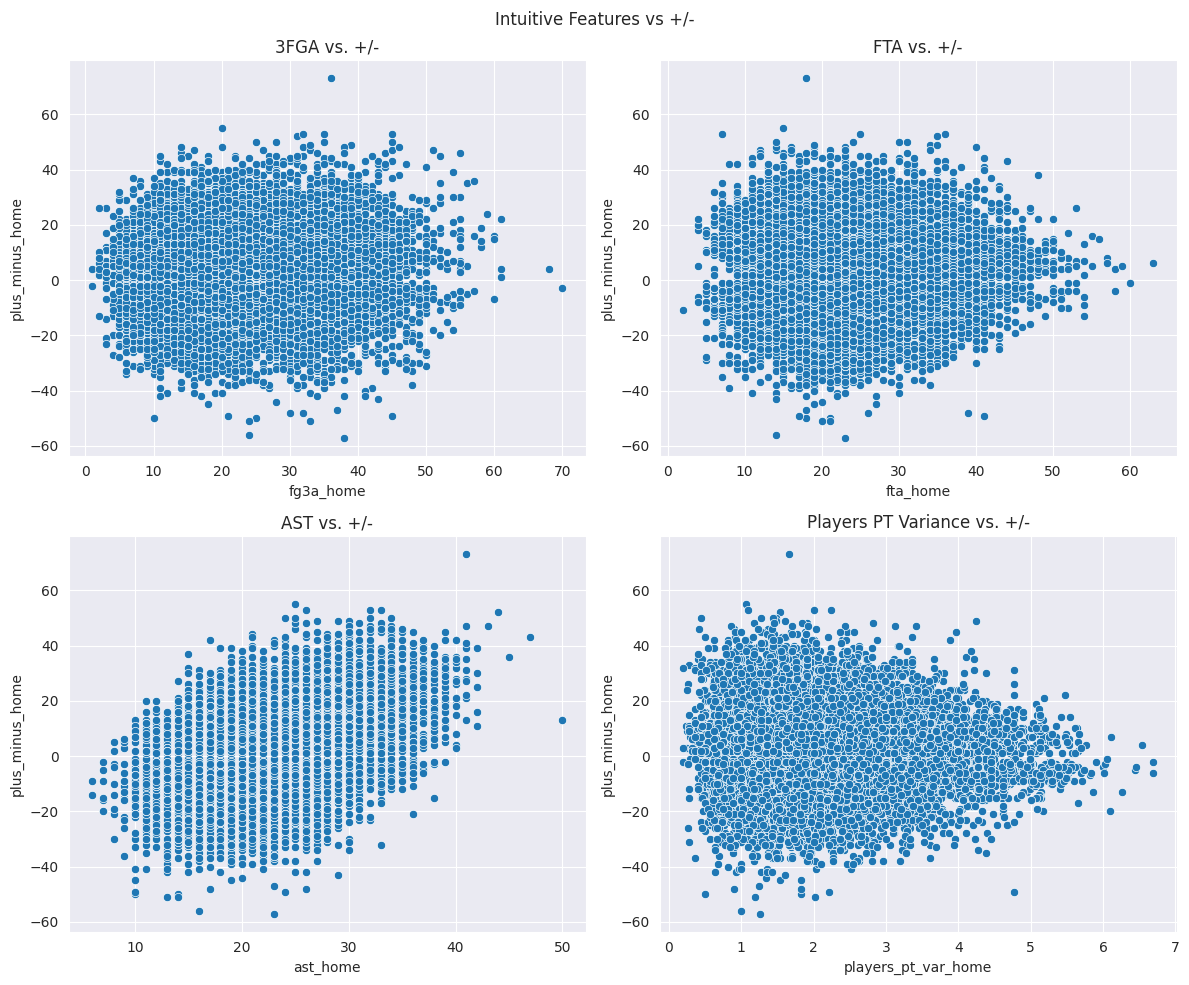

In [ ]:
# scatter plots for more intuitive features
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(x='fg3a_home', y='plus_minus_home', data=game_df, ax=axs[0, 0])
sns.scatterplot(x='fta_home', y='plus_minus_home', data=game_df, ax=axs[0, 1])
sns.scatterplot(x='ast_home', y='plus_minus_home', data=game_df, ax=axs[1, 0])
sns.scatterplot(x='players_pt_var_home', y='plus_minus_home', data=game_df, ax=axs[1, 1])

# titles and labels
axs[0, 0].set_title('3FGA vs. +/-')
axs[0, 1].set_title('FTA vs. +/-')
axs[1, 0].set_title('AST vs. +/-')
axs[1, 1].set_title('Players PT Variance vs. +/-')
fig.suptitle('Intuitive Features vs +/-')
plt.tight_layout()
plt.show()

Our intuition did not serve us as well as we thought it would. In particular, 3 point attempts and free throws attempted are not very correlated with a team's final plus minus. This finding is interesting, and suggests that the modern styles of prioritizing the 3 point or drawing fouls are not as viable as media makes it out to be. 

On the other hand, assists and player point variance do have some correlation with the plus minus. Assists have a strong positive correlation, implying that more assists equals more points. In a way, this correlation may be influenced by the fact that assists can only be counted on shots that counted, i.e. went in for points. Thus, it's correlation is more of an overlap. We had originally wanted to see if more assists led to more points due to a higher level of team play. The variance plot is also quite interesting. The less variance in the players points variance, the more volatile the plus minus score is likely to be. As you increase the players point variance, the more stable the plus minus score becomes. This implies that teams with their points spread evenly tend to lose by a lot or win by a lot, while teams with their points spread apart tend to have close games. 

##Correlation Matrix

After looking at the plots that capture our intuition, let us plot a heat map to see what what features the data tell us are correlated with the plus minus score. 

<ipython-input-67-1e9040408c25>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = game_df.corr()


Text(0.5, 1.0, 'Heat Map')

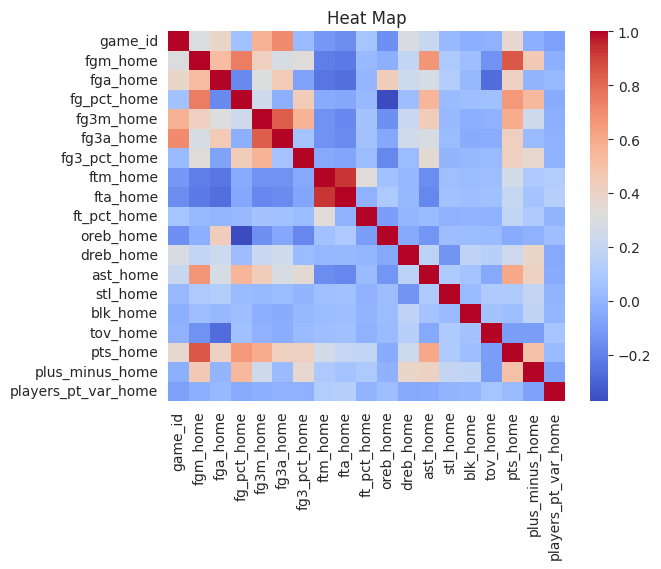

In [ ]:
# correlation matrix
corr = game_df.corr()
sns.heatmap(corr, cmap='coolwarm')
plt.title('Heat Map')

The heat map tells us that the factors that most influence the plus minus score are the following: 
*   Field goals made (fgm_home)
*   Field goal percentage (fg_pct_home)
*   3 Point Percentage (fg3_pct_home)
*   Defensive Rebounds (dreb_home)
*   Assists (ast_home)
*   Points (pts_home)

An interesting point here is that defensive rebounds are much more correlated with the plus minus score than offensive rebounds. This is explored in the next section.

##Correlated Features

We have already explored the assists correlation in our intuition section, and clearly points will overlap in its correlation with the point plus minus, thus, let us graph the other four features. 

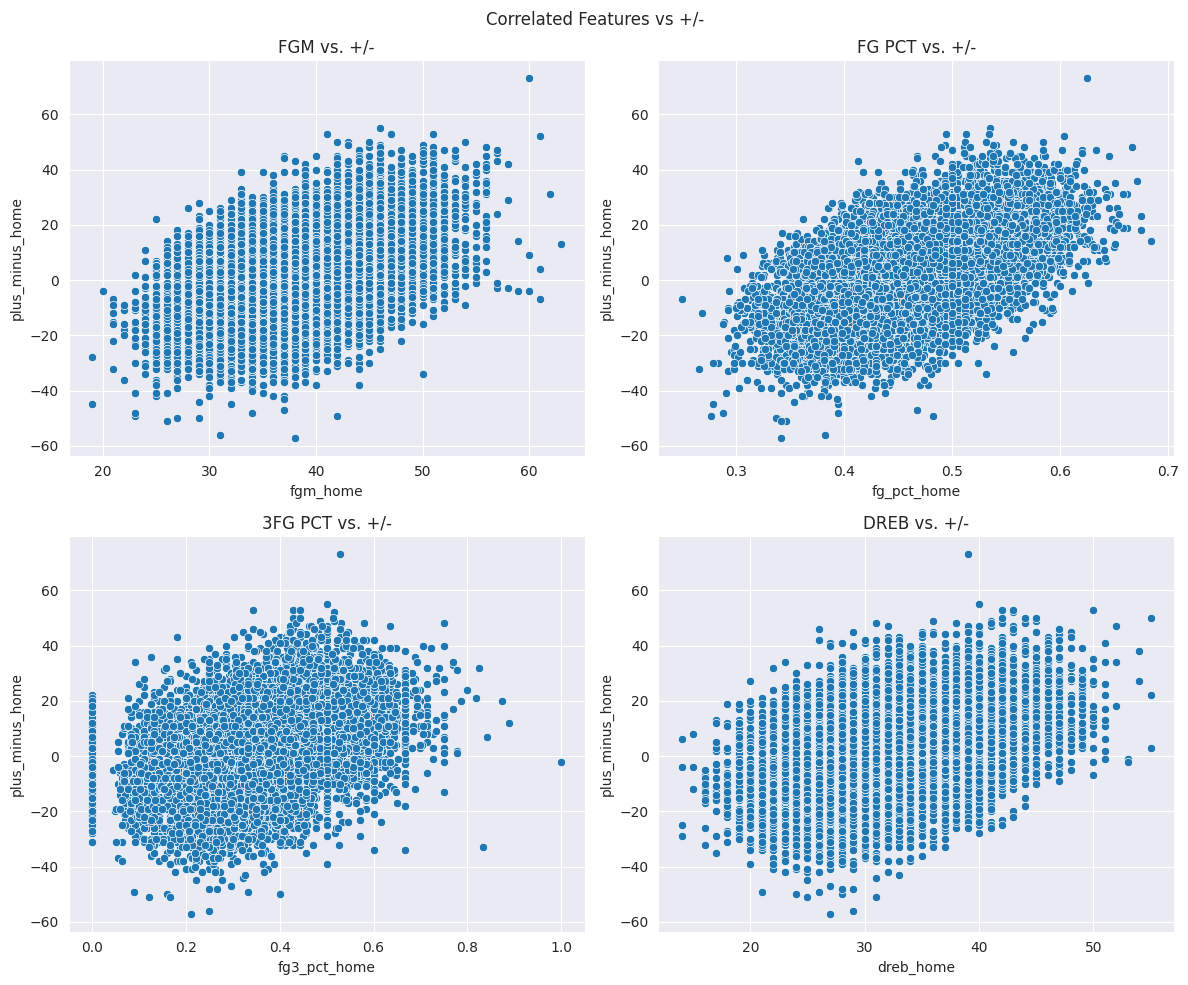

In [ ]:
# scatter plots for correlated features
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(x='fgm_home', y='plus_minus_home', data=game_df, ax=axs[0, 0])
sns.scatterplot(x='fg_pct_home', y='plus_minus_home', data=game_df, ax=axs[0, 1])
sns.scatterplot(x='fg3_pct_home', y='plus_minus_home', data=game_df, ax=axs[1, 0])
sns.scatterplot(x='dreb_home', y='plus_minus_home', data=game_df, ax=axs[1, 1])

# titles and labels
axs[0, 0].set_title('FGM vs. +/-')
axs[0, 1].set_title('FG PCT vs. +/-')
axs[1, 0].set_title('3FG PCT vs. +/-')
axs[1, 1].set_title('DREB vs. +/-')
fig.suptitle('Correlated Features vs +/-')
plt.tight_layout()
plt.show()

##A Closer Look at Rebounding: Offensive vs Defensive Rebounds

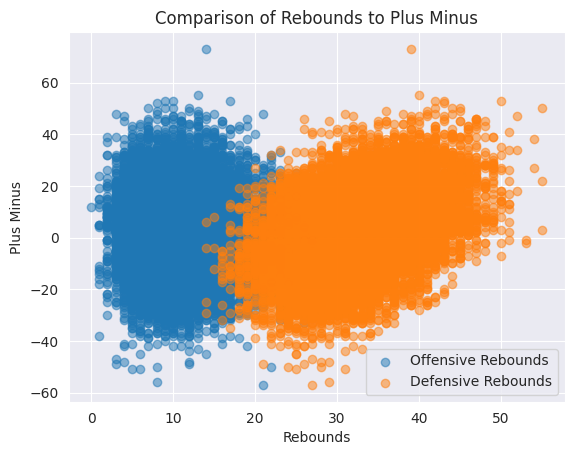

In [ ]:
# scatter plot
plt.scatter(game_df['oreb_home'], game_df['plus_minus_home'], label='Offensive Rebounds', alpha=0.5)
plt.scatter(game_df['dreb_home'], game_df['plus_minus_home'], label='Defensive Rebounds', alpha=0.5)

# axis labels and title
plt.xlabel('Rebounds')
plt.ylabel('Plus Minus')
plt.title('Comparison of Rebounds to Plus Minus')

# legend
plt.legend()

# plot
plt.show()

##A Closer Look at the 3 Point Shot

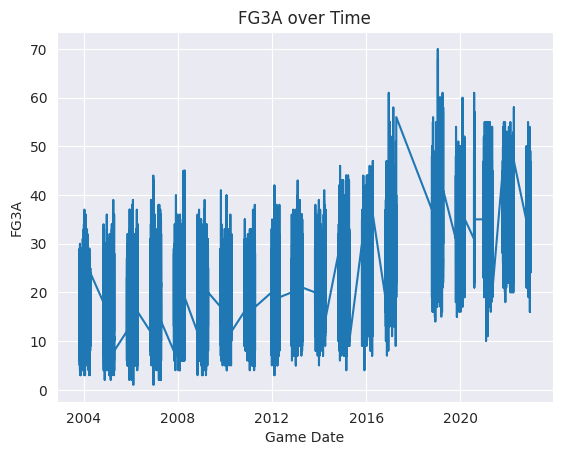

In [ ]:
# time plot
plt.plot(game_df['game_date'], game_df['fg3a_home'])

# axis labels and title
plt.xlabel('Game Date')
plt.ylabel('FG3A')
plt.title('FG3A over Time')

# plot
plt.show()

# Feature Engineering

# Modeling

## Base Model: Linear Regression

## Metrics: LInear Regression R2 Score

## A Better Model: ___

## Metrics: ___